## PACS Domain Generalization with Vision Transformer (ViT)

## Setup & Imports

In [1]:

import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random


c:\Users\Haseeb\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configuration & Seeds

In [2]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
SEED = 42
BATCH_SIZE = 24
NUM_EPOCHS = 5
NUM_CLASSES = 7
DATA_ROOT = "../../../pacs_data/pacs_data"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
MODELS = {
    "base": "google/vit-base-patch16-224-in21k",
    "small": "WinKawaks/vit-small-patch16-224",
    "tiny": "WinKawaks/vit-tiny-patch16-224"
    }

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


Device: cuda


In [3]:
# =================================================================================
# GRQO Model and Training Hyperparameters
# =================================================================================
NUM_QUERIES = 30           # Number of learnable queries for the decoder
NUM_DECODER_LAYERS = 2     # Number of layers in the Transformer Decoder
DECODER_NHEAD = 8          # Number of attention heads in the decoder

# GRQO Loss weights from the DINO-R1 paper (can be tuned)
# We can start with smaller values as our rewards are different
GRQO_ALPHA = 1.0           # Weight for the policy/reward loss
GRQO_BETA = 0.05           # Weight for the KL-divergence regularization

## Dataset Wrapper Class

In [4]:

class PACSDataset:
    def __init__(self, data_root, domains, transform):
        self.data_root = data_root
        self.domains = domains
        self.transform = transform

    def get_dataloader(self, domain, train=True):
        dataset = datasets.ImageFolder(os.path.join(self.data_root, domain), transform=self.transform)
        
        indices = list(range(len(dataset)))
        train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[dataset.targets[i] for i in indices], random_state=SEED)
        selected_idx = train_idx if train else val_idx
        
        subset = Subset(dataset, selected_idx)
        loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=train)
        return loader


## Vision Transformer Wrapper Class

In [5]:
# =================================================================================
# Vision Transformer GRQO Wrapper Class (Replaces the old ViTModel)
# =================================================================================

from transformers import ViTModel # <-- Note the change from ViTForImageClassification

class ViT_GRQO_Model(nn.Module):
    """
    A hybrid Vision Transformer (ViT) and Transformer Decoder model inspired by DETR/DINO.
    This model adapts the architecture for a classification task trained with GRQO.
    """
    def __init__(self,
                 num_classes,
                 model_size="base",
                 num_queries=30,
                 num_decoder_layers=2,
                 decoder_nhead=8):
        """
        Initializes the hybrid model.

        Args:
            num_classes (int): The number of output classes.
            model_size (str): The size of the ViT model ('base', 'small', 'tiny').
            num_queries (int): The number of learnable "object queries" to use in the decoder.
            num_decoder_layers (int): The number of layers in the Transformer Decoder.
            decoder_nhead (int): The number of attention heads in the Transformer Decoder.
        """
        super().__init__()
        
        model_name = MODELS[model_size]
        
        # 1. Load the ViT model as a feature extractor (backbone)
        # We use ViTModel to get the raw hidden states, not the final classification output.
        self.model = ViTModel.from_pretrained(model_name)
        
        # Get the embedding dimension from the ViT config
        embed_dim = self.model.config.hidden_size
        self.embed_dim = embed_dim
        self.num_queries = num_queries

        # 2. Create the learnable query embeddings
        self.query_embed = nn.Embedding(num_queries, embed_dim)

        # 3. Create the Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=decoder_nhead,
            batch_first=True  # Important for easier tensor manipulation
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # 4. Create the final classification head (MLP)
        # This single head will be applied to the output of every query
        self.classifier = nn.Linear(embed_dim, num_classes)
        
        print(f"Initialized ViT-GRQO Model (ViT-{model_size}) with {num_queries} queries.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model.

        Args:
            x (torch.Tensor): Input batch of images with shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Logits for each query, with shape (batch_size, num_queries, num_classes).
        """
        # 1. Get image features from the ViT backbone
        # We don't use the pooler output, just the sequence of patch embeddings
        outputs = self.model(pixel_values=x)
        patch_embeds = outputs.last_hidden_state # Shape: (batch_size, num_patches + 1, embed_dim)
        
        # We don't strictly need to remove the [CLS] token, but it's good practice
        patch_embeds = patch_embeds[:, 1:, :] # Shape: (batch_size, num_patches, embed_dim)

        # 2. Prepare the queries for the decoder
        # Get the learnable query vectors and expand them for the batch
        query_embed = self.query_embed.weight.unsqueeze(0).repeat(x.size(0), 1, 1)

        # 3. Pass features and queries through the decoder
        # `query_embed` is the target (tgt), `patch_embeds` is the memory
        decoder_output = self.decoder(tgt=query_embed, memory=patch_embeds)
        # Shape: (batch_size, num_queries, embed_dim)

        # 4. Apply the classifier to each query's output
        logits = self.classifier(decoder_output)
        # Shape: (batch_size, num_queries, num_classes)

        return logits

## Trainer Class

In [6]:
# =================================================================================
# Trainer Class (Replaces the old Trainer)
# =================================================================================
import torch.nn.functional as F
import copy

class Trainer:
    """
    A trainer class to handle the training and evaluation loop, now with GRQO logic.
    """
    def __init__(self, model, optimizer, criterion, grqo_alpha=0.5, grqo_beta=0.01):
        """
        Initializes the Trainer.

        Args:
            model: The model to be trained (our new ViT_GRQO_Model).
            optimizer: The optimizer.
            criterion: The base loss function (e.g., CrossEntropyLoss).
            grqo_alpha (float): The weight for the GRQO policy loss.
            grqo_beta (float): The weight for the KL-divergence regularization loss.
        """
        self.model = model.to(DEVICE)
        self.optimizer = optimizer
        self.criterion = criterion
        
        # Store GRQO hyperparameters
        self.alpha = grqo_alpha
        self.beta = grqo_beta
        
        # Initialize the reference model placeholder
        self.ref_model = None
        
        print(f"Initialized Trainer with GRQO (alpha={self.alpha}, beta={self.beta}).")
        
    def update_reference_model(self):
        """
        Creates a frozen, deep copy of the current model to be used as the
        reference model for KL-divergence calculation.
        This should be called at the beginning of each epoch.
        """
        print("Updating reference model...")
        if self.ref_model is None:
            self.ref_model = copy.deepcopy(self.model)
        else:
            self.ref_model.load_state_dict(self.model.state_dict())
        
        # Set the reference model to evaluation mode and freeze its parameters
        self.ref_model.eval()
        for param in self.ref_model.parameters():
            param.requires_grad = False
        print("Reference model updated successfully.")

    def train(self, dataloader):
        """
        Runs a single training epoch with the composite GRQO loss.
        """
        self.model.train()
        total_loss_epoch = 0

        for inputs, labels in tqdm(dataloader, desc="Training"):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            # --- Forward Passes ---
            # 1. Get logits from the active model (gradients will flow)
            active_logits = self.model(inputs) # Shape: (B, num_queries, num_classes)

            # 2. Get logits from the reference model (no gradients)
            with torch.no_grad():
                ref_logits = self.ref_model(inputs) # Shape: (B, num_queries, num_classes)

            # --- Loss Calculation ---
            # Component 1: Standard Supervised Loss (loss_sft)
            # This loss is based on the averaged prediction of all queries.
            avg_active_logits = active_logits.mean(dim=1)
            loss_sft = self.criterion(avg_active_logits, labels)

            # Component 2: GRQO Policy Loss (loss_grqo)
            # We need to calculate rewards for each query.
            # a. Calculate per-query cross-entropy loss
            #    (B, N_q, N_c) -> (B, N_c, N_q) for F.cross_entropy
            #    reduction='none' gives us loss for each item in the batch
            per_query_loss = F.cross_entropy(
                active_logits.permute(0, 2, 1), 
                labels.unsqueeze(1).repeat(1, self.model.num_queries), 
                reduction='none'
            ) # Shape: (B, num_queries)
            
            # b. Rewards are the negative loss
            rewards = -per_query_loss
            
            # c. Normalize rewards to get advantages (stop gradients here)
            mean_rewards = rewards.mean(dim=1, keepdim=True)
            std_rewards = rewards.std(dim=1, keepdim=True)
            advantages = (rewards - mean_rewards) / (std_rewards + 1e-9)
            advantages = advantages.detach()
            
            # d. Calculate policy loss (negative of advantage-weighted log-probs)
            log_probs = F.log_softmax(active_logits, dim=-1)
            # Gather the log-probs for the ground-truth labels for each query
            gt_log_probs = log_probs.gather(2, labels.view(-1, 1, 1).repeat(1, self.model.num_queries, 1)).squeeze(-1)
            loss_grqo = - (advantages * gt_log_probs).mean()
            
            # Component 3: KL-Divergence Loss (loss_kl)
            # This keeps the active model from straying too far from the reference model.
            loss_kl = F.kl_div(
                F.log_softmax(active_logits, dim=-1),
                F.softmax(ref_logits.detach(), dim=-1),
                reduction='batchmean' # 'batchmean' averages the loss over the batch
            )

            # --- Total Loss and Backpropagation ---
            total_loss = loss_sft + self.alpha * loss_grqo + self.beta * loss_kl
            
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
            
            total_loss_epoch += total_loss.item()
            
        return total_loss_epoch / len(dataloader)

    def evaluate(self, dataloader):
        """
        Runs a single evaluation epoch.
        """
        self.model.eval()
        total_correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader, desc="Evaluating"):
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                
                # Get per-query logits from the model
                outputs = self.model(inputs) # Shape: (B, num_queries, num_classes)
                
                # For evaluation, we average the predictions of all queries
                avg_outputs = outputs.mean(dim=1)
                
                preds = torch.argmax(avg_outputs, dim=1)
                
                total_correct += (preds == labels).sum().item()
                total += labels.size(0)
                
        return total_correct / total

## Base ViT

### Leave-One-Domain-Out (LODO) Training

In [7]:
# =================================================================================
# GRQO + ViT Base Leave-One-Domain-Out (LODO) Training
# =================================================================================

# Image transformations remain the same
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # Normalizing for 3 channels
])

results_base = {}

for test_domain in DOMAINS:
    print(f"--- Testing on domain: {test_domain} ---")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # --- Load datasets ---
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # --- Concatenate datasets ---
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # --- Initialize model, optimizer, and criterion ---
    # Use the new ViT_GRQO_Model
    model_base = ViT_GRQO_Model(
        num_classes=NUM_CLASSES,
        model_size="base",
        num_queries=NUM_QUERIES,
        num_decoder_layers=NUM_DECODER_LAYERS,
        decoder_nhead=DECODER_NHEAD
    )
    optimizer = optim.Adam(model_base.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # Use the new Trainer with GRQO parameters
    trainer = Trainer(
        model_base, 
        optimizer, 
        criterion, 
        grqo_alpha=GRQO_ALPHA, 
        grqo_beta=GRQO_BETA
    )

    # --- Train ---
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        
        # !! CRITICAL STEP !! Update the reference model at the start of each epoch
        trainer.update_reference_model()
        
        train_loss_base = trainer.train(train_loader)
        val_acc_base = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss_base:.4f} | Val Acc: {val_acc_base:.4f}")

    # --- Test ---
    test_acc_base = trainer.evaluate(test_loader)
    results_base[test_domain] = test_acc_base
    print(f"Test Accuracy on {test_domain}: {test_acc_base:.4f}")

--- Testing on domain: art_painting ---
Initialized ViT-GRQO Model (ViT-base) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 15.97it/s]


Train Loss: -4.7752 | Val Acc: 0.9434
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 16.20it/s]


Train Loss: -24.1503 | Val Acc: 0.9289
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 16.01it/s]


Train Loss: -47.1613 | Val Acc: 0.7615
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 16.14it/s]


Train Loss: -67.0989 | Val Acc: 0.4959
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:04<00:00, 16.21it/s]


Train Loss: -92.9628 | Val Acc: 0.4519


Evaluating: 100%|██████████| 18/18 [00:01<00:00, 16.14it/s]


Test Accuracy on art_painting: 0.4512
--- Testing on domain: cartoon ---
Initialized ViT-GRQO Model (ViT-base) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:04<00:00, 15.89it/s]


Train Loss: -4.5825 | Val Acc: 0.6869
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:04<00:00, 15.73it/s]


Train Loss: -25.2325 | Val Acc: 0.9301
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:04<00:00, 15.80it/s]


Train Loss: -43.6307 | Val Acc: 0.8791
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:04<00:00, 15.86it/s]


Train Loss: -62.3110 | Val Acc: 0.9039
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:03<00:00, 16.02it/s]


Train Loss: -82.3921 | Val Acc: 0.9327


Evaluating: 100%|██████████| 20/20 [00:01<00:00, 16.88it/s]


Test Accuracy on cartoon: 0.7612
--- Testing on domain: photo ---
Initialized ViT-GRQO Model (ViT-base) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 16.70it/s]


Train Loss: -4.7948 | Val Acc: 0.6535
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 16.81it/s]


Train Loss: -26.9612 | Val Acc: 0.9123
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 16.69it/s]


Train Loss: -47.6833 | Val Acc: 0.9003
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 16.74it/s]


Train Loss: -65.2893 | Val Acc: 0.6018
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:04<00:00, 16.74it/s]


Train Loss: -75.0846 | Val Acc: 0.2631


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 16.46it/s]


Test Accuracy on photo: 0.1317
--- Testing on domain: sketch ---
Initialized ViT-GRQO Model (ViT-base) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:03<00:00, 16.00it/s]


Train Loss: -3.8621 | Val Acc: 0.9448
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:03<00:00, 15.97it/s]


Train Loss: -17.4458 | Val Acc: 0.7832
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:03<00:00, 15.83it/s]


Train Loss: -30.6397 | Val Acc: 0.9382
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:03<00:00, 15.44it/s]


Train Loss: -47.6752 | Val Acc: 0.9538
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:03<00:00, 15.93it/s]


Train Loss: -65.9037 | Val Acc: 0.9456


Evaluating: 100%|██████████| 33/33 [00:01<00:00, 16.59it/s]

Test Accuracy on sketch: 0.6450


### Baseline

In [8]:
# =================================================================================
# GRQO + ViT Base Baseline Training (All Domains)
# =================================================================================

print("\n--- Baseline: training on all domains with GRQO and testing on mixed domains ---")

# --- Load full train and test sets ---
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# --- Concatenate ---
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])

full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# --- Initialize baseline model with GRQO ---
baseline_model_base = ViT_GRQO_Model(
    num_classes=NUM_CLASSES, 
    model_size="base",
    num_queries=NUM_QUERIES,
    num_decoder_layers=NUM_DECODER_LAYERS,
    decoder_nhead=DECODER_NHEAD
)
baseline_optimizer = optim.Adam(baseline_model_base.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()

# Use the new Trainer with GRQO parameters
baseline_trainer = Trainer(
    baseline_model_base, 
    baseline_optimizer, 
    baseline_criterion,
    grqo_alpha=GRQO_ALPHA, 
    grqo_beta=GRQO_BETA
)

# --- Train baseline ---
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    
    # !! CRITICAL STEP !! Update the reference model at the start of each epoch
    baseline_trainer.update_reference_model()

    baseline_loss_base = baseline_trainer.train(full_train_loader)
    baseline_val_acc_base = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_base:.4f} | Baseline Acc: {baseline_val_acc_base:.4f}")

# --- Test baseline ---
baseline_test_acc_base = baseline_trainer.evaluate(full_test_loader)

# Store the result in the same dictionary for easy plotting
results_base['baseline_all_domains'] = baseline_test_acc_base
print(f"Baseline Test Accuracy: {baseline_test_acc_base:.4f}")


--- Baseline: training on all domains with GRQO and testing on mixed domains ---
Initialized ViT-GRQO Model (ViT-base) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Baseline Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 16.31it/s]


Baseline Loss: -5.5875 | Baseline Acc: 0.7899
Baseline Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 16.30it/s]


Baseline Loss: -29.1654 | Baseline Acc: 0.8719
Baseline Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 16.15it/s]


Baseline Loss: -50.7004 | Baseline Acc: 0.5128
Baseline Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 15.99it/s]


Baseline Loss: -76.0043 | Baseline Acc: 0.7099
Baseline Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 16.15it/s]


Baseline Loss: -104.4866 | Baseline Acc: 0.7349


Evaluating: 100%|██████████| 84/84 [00:05<00:00, 16.30it/s]

Baseline Test Accuracy: 0.7349


### Visual Comparison

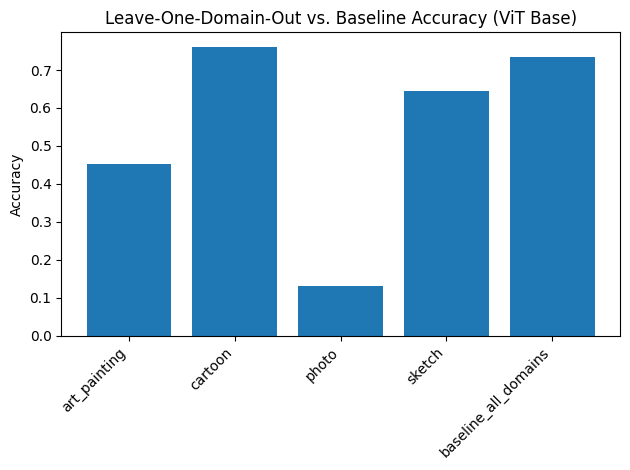

In [9]:
domains = list(results_base.keys())
accuracies = [results_base[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Base)')
plt.tight_layout()
plt.show()

### Final Results

In [10]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_base.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_base.values()) / len(results_base)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.4512
cartoon: 0.7612
photo: 0.1317
sketch: 0.6450
baseline_all_domains: 0.7349

Average Accuracy: 0.5448


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_7252\165815634.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## WinKawaks/ViT Small

### Leave-One-Domain-Out (LODO) Training

In [11]:
# =================================================================================
# GRQO + ViT Small Leave-One-Domain-Out (LODO) Training
# =================================================================================

results_small = {}

for test_domain in DOMAINS:
    print(f"---[ViT Small]--- Testing on domain: {test_domain} ---")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # --- Load datasets ---
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # --- Concatenate datasets ---
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # --- Initialize model, optimizer, and criterion ---
    model_small = ViT_GRQO_Model(
        num_classes=NUM_CLASSES,
        model_size="small",
        num_queries=NUM_QUERIES,
        num_decoder_layers=NUM_DECODER_LAYERS,
        decoder_nhead=DECODER_NHEAD
    )
    optimizer_small = optim.Adam(model_small.parameters(), lr=1e-4)
    criterion_small = nn.CrossEntropyLoss()
    
    trainer_small = Trainer(
        model_small, 
        optimizer_small, 
        criterion_small, 
        grqo_alpha=GRQO_ALPHA, 
        grqo_beta=GRQO_BETA
    )

    # --- Train ---
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        trainer_small.update_reference_model()
        
        train_loss_small = trainer_small.train(train_loader)
        val_acc_small = trainer_small.evaluate(val_loader)
        print(f"Train Loss: {train_loss_small:.4f} | Val Acc: {val_acc_small:.4f}")

    # --- Test ---
    test_acc_small = trainer_small.evaluate(test_loader)
    results_small[test_domain] = test_acc_small
    print(f"Test Accuracy on {test_domain}: {test_acc_small:.4f}")

---[ViT Small]--- Testing on domain: art_painting ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-small) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 22.90it/s]


Train Loss: -1.6663 | Val Acc: 0.6627
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 23.95it/s]


Train Loss: -10.8947 | Val Acc: 0.9239
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 23.46it/s]


Train Loss: -19.0692 | Val Acc: 0.8798
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 23.03it/s]


Train Loss: -26.3877 | Val Acc: 0.9075
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 23.96it/s]


Train Loss: -35.1729 | Val Acc: 0.9062


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 21.60it/s]


Test Accuracy on art_painting: 0.6878
---[ViT Small]--- Testing on domain: cartoon ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-small) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 23.68it/s]


Train Loss: -1.6610 | Val Acc: 0.7601
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 22.34it/s]


Train Loss: -10.1374 | Val Acc: 0.9203
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 23.46it/s]


Train Loss: -17.3264 | Val Acc: 0.8824
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 22.52it/s]


Train Loss: -23.7269 | Val Acc: 0.8915
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 22.51it/s]


Train Loss: -32.1816 | Val Acc: 0.8490


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 21.82it/s]


Test Accuracy on cartoon: 0.6972
---[ViT Small]--- Testing on domain: photo ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-small) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:03<00:00, 22.00it/s]


Train Loss: -1.7241 | Val Acc: 0.4793
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:03<00:00, 22.85it/s]


Train Loss: -10.7303 | Val Acc: 0.8997
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:03<00:00, 22.54it/s]


Train Loss: -18.8685 | Val Acc: 0.9117
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:03<00:00, 22.23it/s]


Train Loss: -27.0872 | Val Acc: 0.9231
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:02<00:00, 23.49it/s]


Train Loss: -36.0855 | Val Acc: 0.8342


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 21.60it/s]


Test Accuracy on photo: 0.9132
---[ViT Small]--- Testing on domain: sketch ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-small) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 22.28it/s]


Train Loss: -1.7596 | Val Acc: 0.8104
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 22.88it/s]


Train Loss: -9.5990 | Val Acc: 0.9258
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 23.10it/s]


Train Loss: -15.5009 | Val Acc: 0.9299
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 23.34it/s]


Train Loss: -21.7410 | Val Acc: 0.8895
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 23.14it/s]


Train Loss: -27.9717 | Val Acc: 0.9176


Evaluating: 100%|██████████| 33/33 [00:01<00:00, 22.76it/s]

Test Accuracy on sketch: 0.6718


### Baseline

In [12]:
# =================================================================================
# GRQO + ViT Small Baseline Training (All Domains)
# =================================================================================

print("\n---[ViT Small]--- Baseline: training on all domains with GRQO ---")

# Data loading is the same as the 'base' baseline
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# --- Initialize baseline model with GRQO ---
baseline_model_small = ViT_GRQO_Model(
    num_classes=NUM_CLASSES, 
    model_size="small",
    num_queries=NUM_QUERIES,
    num_decoder_layers=NUM_DECODER_LAYERS,
    decoder_nhead=DECODER_NHEAD
)
baseline_optimizer_small = optim.Adam(baseline_model_small.parameters(), lr=1e-4)
baseline_criterion_small = nn.CrossEntropyLoss()

baseline_trainer_small = Trainer(
    baseline_model_small, 
    baseline_optimizer_small, 
    baseline_criterion_small,
    grqo_alpha=GRQO_ALPHA, 
    grqo_beta=GRQO_BETA
)

# --- Train baseline ---
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_trainer_small.update_reference_model()

    baseline_loss_small = baseline_trainer_small.train(full_train_loader)
    baseline_val_acc_small = baseline_trainer_small.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_small:.4f} | Baseline Acc: {baseline_val_acc_small:.4f}")

# --- Test baseline ---
baseline_test_acc_small = baseline_trainer_small.evaluate(full_test_loader)
results_small['baseline_all_domains'] = baseline_test_acc_small
print(f"Baseline Test Accuracy: {baseline_test_acc_small:.4f}")


---[ViT Small]--- Baseline: training on all domains with GRQO ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-small) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Baseline Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 22.30it/s]


Baseline Loss: -2.3709 | Baseline Acc: 0.6398
Baseline Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 21.97it/s]


Baseline Loss: -14.0343 | Baseline Acc: 0.9125
Baseline Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 22.40it/s]


Baseline Loss: -25.5557 | Baseline Acc: 0.7874
Baseline Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 22.98it/s]


Baseline Loss: -34.1920 | Baseline Acc: 0.6308
Baseline Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 22.17it/s]


Baseline Loss: -42.7229 | Baseline Acc: 0.3922


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 21.13it/s]

Baseline Test Accuracy: 0.3922


### Visual Comparison

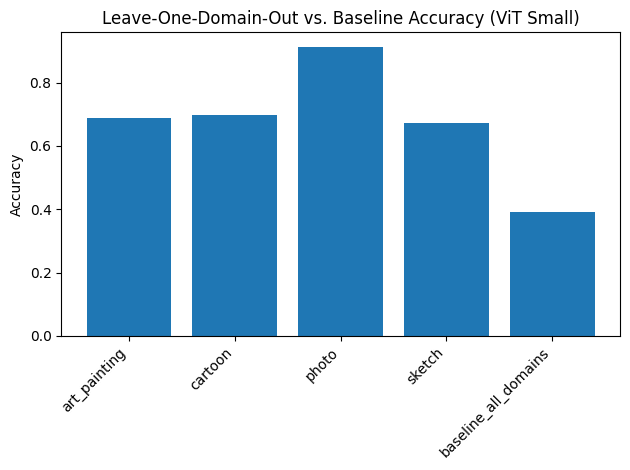

In [13]:
domains = list(results_small.keys())
accuracies = [results_small[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Small)')
plt.tight_layout()
plt.show()

### Final Results

In [14]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_small.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_small.values()) / len(results_small)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.6878
cartoon: 0.6972
photo: 0.9132
sketch: 0.6718
baseline_all_domains: 0.3922

Average Accuracy: 0.6724


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_7252\3963232904.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## WinKawaks/ViT Tiny

### Leave-One-Domain-Out (LODO) Training

In [15]:
# =================================================================================
# GRQO + ViT Tiny Leave-One-Domain-Out (LODO) Training
# =================================================================================

results_tiny = {}

for test_domain in DOMAINS:
    print(f"---[ViT Tiny]--- Testing on domain: {test_domain} ---")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # --- Load datasets ---
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # --- Concatenate datasets ---
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # --- Initialize model, optimizer, and criterion ---
    model_tiny = ViT_GRQO_Model(
        num_classes=NUM_CLASSES,
        model_size="tiny",
        num_queries=NUM_QUERIES,
        num_decoder_layers=NUM_DECODER_LAYERS,
        decoder_nhead=DECODER_NHEAD
    )
    optimizer_tiny = optim.Adam(model_tiny.parameters(), lr=1e-4)
    criterion_tiny = nn.CrossEntropyLoss()
    
    trainer_tiny = Trainer(
        model_tiny, 
        optimizer_tiny, 
        criterion_tiny, 
        grqo_alpha=GRQO_ALPHA, 
        grqo_beta=GRQO_BETA
    )

    # --- Train ---
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        trainer_tiny.update_reference_model()
        
        train_loss_tiny = trainer_tiny.train(train_loader)
        val_acc_tiny = trainer_tiny.evaluate(val_loader)
        print(f"Train Loss: {train_loss_tiny:.4f} | Val Acc: {val_acc_tiny:.4f}")

    # --- Test ---
    test_acc_tiny = trainer_tiny.evaluate(test_loader)
    results_tiny[test_domain] = test_acc_tiny
    print(f"Test Accuracy on {test_domain}: {test_acc_tiny:.4f}")

---[ViT Tiny]--- Testing on domain: art_painting ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-tiny) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 24.74it/s]


Train Loss: -0.3888 | Val Acc: 0.6589
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 27.43it/s]


Train Loss: -5.9366 | Val Acc: 0.9025
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 25.69it/s]


Train Loss: -11.4108 | Val Acc: 0.8792
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 25.62it/s]


Train Loss: -16.1912 | Val Acc: 0.8043
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 67/67 [00:02<00:00, 25.23it/s]


Train Loss: -20.6369 | Val Acc: 0.8622


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 24.45it/s]


Test Accuracy on art_painting: 0.6049
---[ViT Tiny]--- Testing on domain: cartoon ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-tiny) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 24.96it/s]


Train Loss: -0.3864 | Val Acc: 0.6157
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 25.26it/s]


Train Loss: -5.7131 | Val Acc: 0.8967
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 24.86it/s]


Train Loss: -9.8167 | Val Acc: 0.8882
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 25.51it/s]


Train Loss: -13.8961 | Val Acc: 0.8719
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 64/64 [00:02<00:00, 24.77it/s]


Train Loss: -17.9146 | Val Acc: 0.8686


Evaluating: 100%|██████████| 20/20 [00:00<00:00, 24.76it/s]


Test Accuracy on cartoon: 0.6823
---[ViT Tiny]--- Testing on domain: photo ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-tiny) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:02<00:00, 24.81it/s]


Train Loss: -0.4050 | Val Acc: 0.8090
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:02<00:00, 24.40it/s]


Train Loss: -6.3214 | Val Acc: 0.8859
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:03<00:00, 22.17it/s]


Train Loss: -11.0129 | Val Acc: 0.8408
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:02<00:00, 25.00it/s]


Train Loss: -15.6205 | Val Acc: 0.8535
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 70/70 [00:02<00:00, 24.70it/s]


Train Loss: -21.0952 | Val Acc: 0.6961


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 23.33it/s]


Test Accuracy on photo: 0.7695
---[ViT Tiny]--- Testing on domain: sketch ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-tiny) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:01<00:00, 25.71it/s]


Train Loss: -0.3279 | Val Acc: 0.6628
Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 24.29it/s]


Train Loss: -5.3439 | Val Acc: 0.8862
Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:01<00:00, 25.91it/s]


Train Loss: -8.8263 | Val Acc: 0.8986
Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 24.35it/s]


Train Loss: -11.9787 | Val Acc: 0.8887
Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 51/51 [00:02<00:00, 24.51it/s]


Train Loss: -15.3763 | Val Acc: 0.8821


Evaluating: 100%|██████████| 33/33 [00:01<00:00, 24.59it/s]

Test Accuracy on sketch: 0.3842


### Baseline

In [16]:
# =================================================================================
# GRQO + ViT Tiny Baseline Training (All Domains)
# =================================================================================

print("\n---[ViT Tiny]--- Baseline: training on all domains with GRQO ---")

# Data loading is the same as the 'base' baseline
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# --- Initialize baseline model with GRQO ---
baseline_model_tiny = ViT_GRQO_Model(
    num_classes=NUM_CLASSES, 
    model_size="tiny",
    num_queries=NUM_QUERIES,
    num_decoder_layers=NUM_DECODER_LAYERS,
    decoder_nhead=DECODER_NHEAD
)
baseline_optimizer_tiny = optim.Adam(baseline_model_tiny.parameters(), lr=1e-4)
baseline_criterion_tiny = nn.CrossEntropyLoss()

baseline_trainer_tiny = Trainer(
    baseline_model_tiny, 
    baseline_optimizer_tiny, 
    baseline_criterion_tiny,
    grqo_alpha=GRQO_ALPHA, 
    grqo_beta=GRQO_BETA
)

# --- Train baseline ---
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_trainer_tiny.update_reference_model()

    baseline_loss_tiny = baseline_trainer_tiny.train(full_train_loader)
    baseline_val_acc_tiny = baseline_trainer_tiny.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss_tiny:.4f} | Baseline Acc: {baseline_val_acc_tiny:.4f}")

# --- Test baseline ---
baseline_test_acc_tiny = baseline_trainer_tiny.evaluate(full_test_loader)
results_tiny['baseline_all_domains'] = baseline_test_acc_tiny
print(f"Baseline Test Accuracy: {baseline_test_acc_tiny:.4f}")


---[ViT Tiny]--- Baseline: training on all domains with GRQO ---


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-tiny-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initialized ViT-GRQO Model (ViT-tiny) with 30 queries.
Initialized Trainer with GRQO (alpha=1.0, beta=0.05).
Baseline Epoch 1/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 24.62it/s]


Baseline Loss: -0.5045 | Baseline Acc: 0.2331
Baseline Epoch 2/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 24.40it/s]


Baseline Loss: -6.8999 | Baseline Acc: 0.8289
Baseline Epoch 3/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 25.97it/s]


Baseline Loss: -12.9784 | Baseline Acc: 0.8129
Baseline Epoch 4/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 25.22it/s]


Baseline Loss: -19.0361 | Baseline Acc: 0.8214
Baseline Epoch 5/5
Updating reference model...
Reference model updated successfully.


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 24.00it/s]


Baseline Loss: -24.7482 | Baseline Acc: 0.7764


Evaluating: 100%|██████████| 84/84 [00:03<00:00, 23.73it/s]

Baseline Test Accuracy: 0.7764


### Visual Comparison

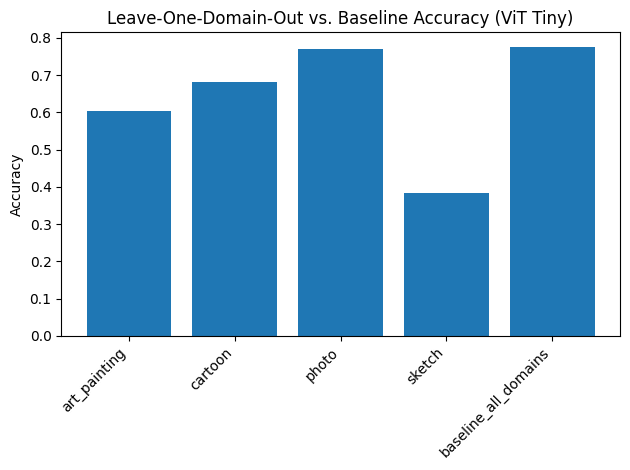

In [17]:
domains = list(results_tiny.keys())
accuracies = [results_tiny[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy (ViT Tiny)')
plt.tight_layout()
plt.show()

### Final Results

In [18]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results_tiny.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results_tiny.values()) / len(results_tiny)
print(f"\nAverage Accuracy: {avg_acc:.4f}")


\Final Results (LODO Accuracy):
art_painting: 0.6049
cartoon: 0.6823
photo: 0.7695
sketch: 0.3842
baseline_all_domains: 0.7764

Average Accuracy: 0.6435


<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:1: SyntaxWarning: invalid escape sequence '\F'
C:\Users\Haseeb\AppData\Local\Temp\ipykernel_7252\1740940439.py:1: SyntaxWarning: invalid escape sequence '\F'
  print("\Final Results (LODO Accuracy):")


## Performance Comparison

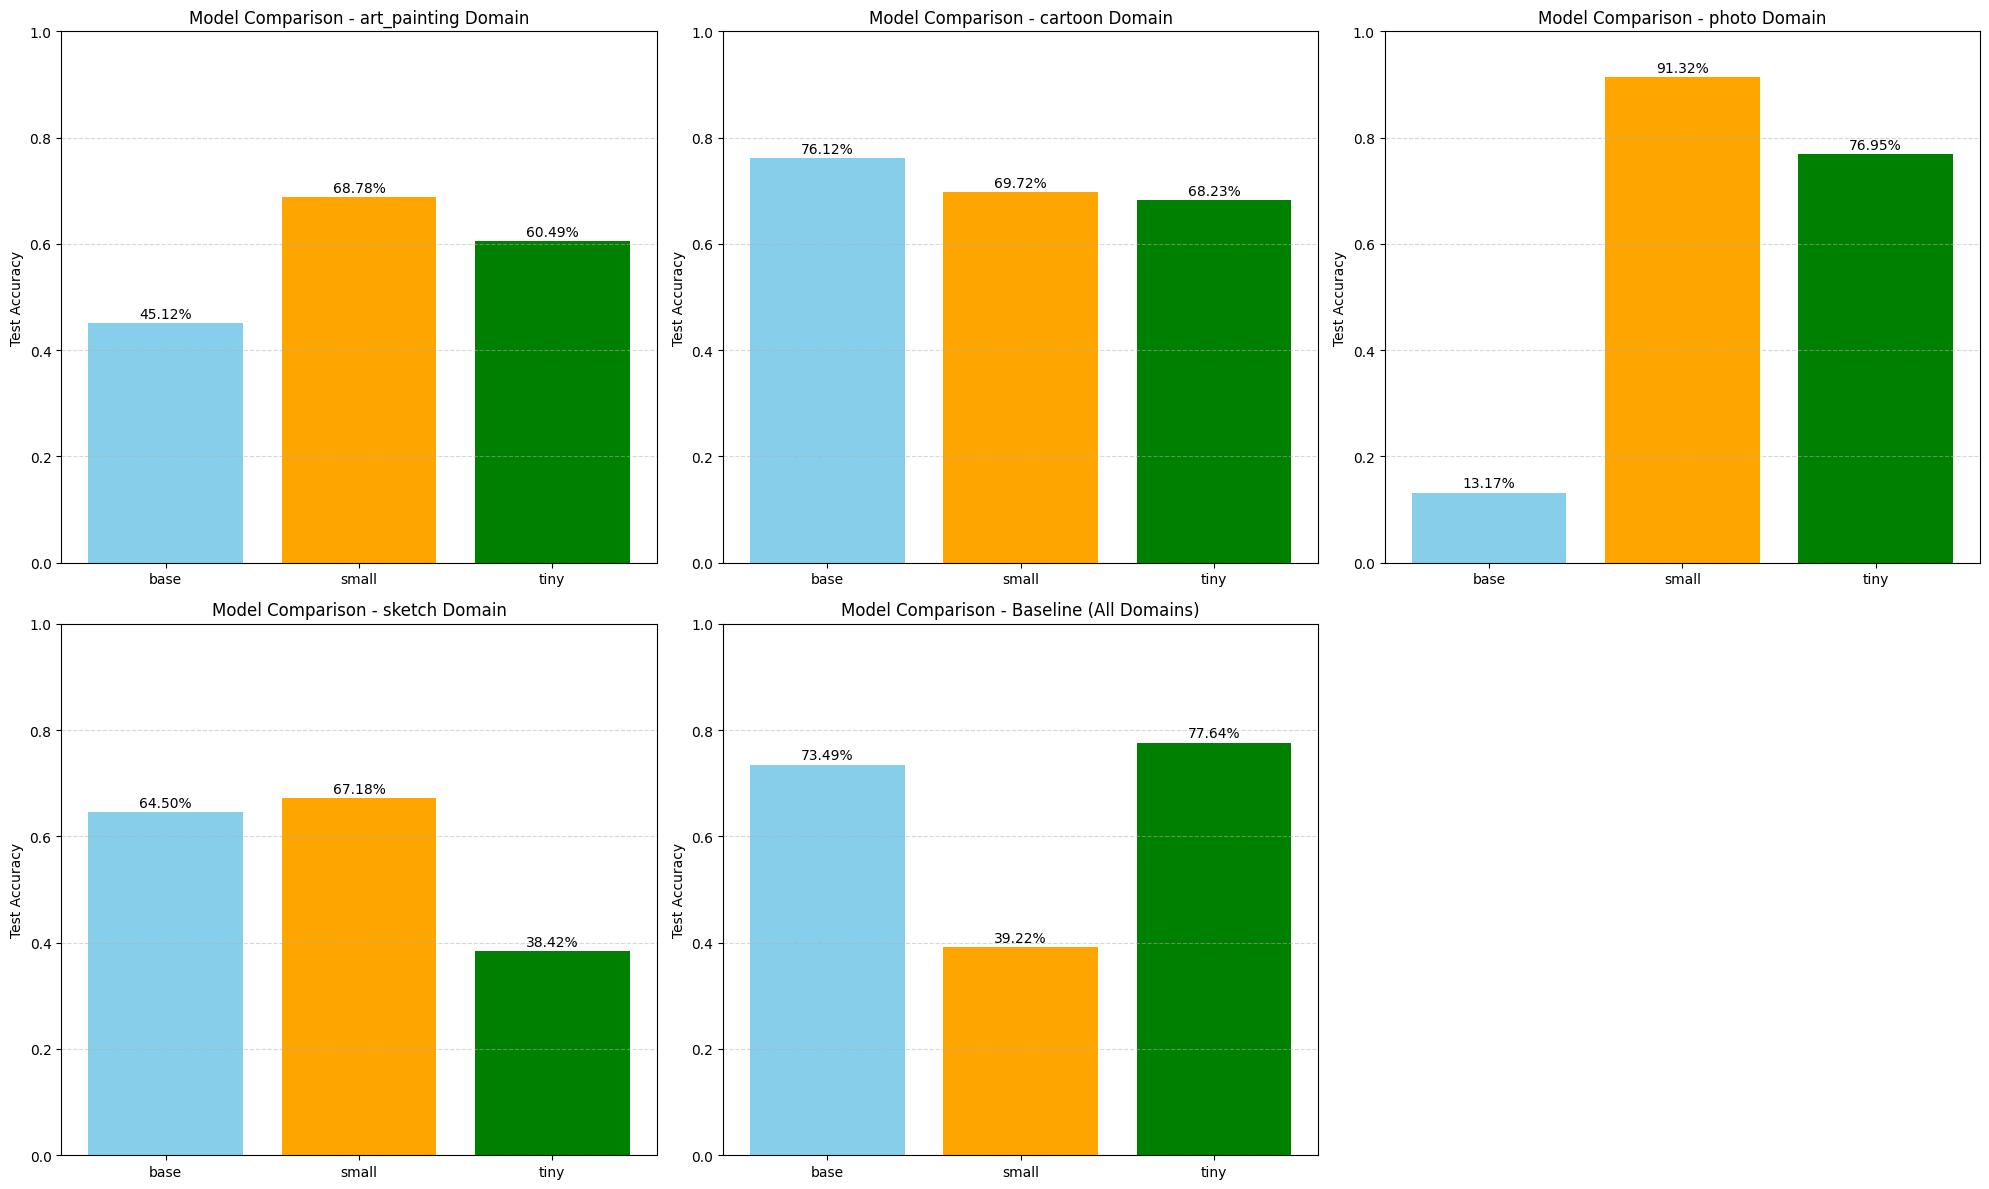


Detailed Performance Comparison:
------------------------------------------------------------
Domain                Base      Small       Tiny
------------------------------------------------------------
art_painting        45.12%     68.78%     60.49%
cartoon             76.12%     69.72%     68.23%
photo               13.17%     91.32%     76.95%
sketch              64.50%     67.18%     38.42%
------------------------------------------------------------
Baseline            73.49%     39.22%     77.64%
------------------------------------------------------------


In [19]:
plt.figure(figsize=(20, 12))

for idx, domain in enumerate(DOMAINS):
    plt.subplot(2, 3, idx + 1)

    domain_accuracies = [
        results_base[domain],
        results_small[domain],
        results_tiny[domain]
    ]

    bars = plt.bar(MODELS.keys(), domain_accuracies, color=["skyblue", "orange", "green"])
    plt.ylim(0, 1)
    plt.ylabel("Test Accuracy")
    plt.title(f"Model Comparison - {domain} Domain")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    
    # Add value labels on top of bars
    for i, acc in enumerate(domain_accuracies):
        plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center")

# Create the baseline comparison subplot
plt.subplot(2, 3, 5) 
baseline_accuracies = [
    results_base["baseline_all_domains"],
    results_small["baseline_all_domains"],
    results_tiny["baseline_all_domains"]
]
plt.bar(MODELS.keys(), baseline_accuracies, color=["skyblue", "orange", "green"])
plt.ylim(0, 1)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison - Baseline (All Domains)")
plt.grid(axis="y", linestyle="--", alpha=0.5)

for i, acc in enumerate(baseline_accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2%}", ha="center")

plt.tight_layout()
plt.show()

print("\nDetailed Performance Comparison:")
print("-" * 60)
print(f"{'Domain':<15} {'Base':>10} {'Small':>10} {'Tiny':>10}")
print("-" * 60)

for domain in DOMAINS:
    print(f"{domain:<15} {results_base[domain]:>10.2%} {results_small[domain]:>10.2%} {results_tiny[domain]:>10.2%}")

print("-" * 60)
print(f"{'Baseline':<15} {results_base['baseline_all_domains']:>10.2%} {results_small['baseline_all_domains']:>10.2%} {results_tiny['baseline_all_domains']:>10.2%}")
print("-" * 60)